In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
heart = pd.read_csv("heart.csv")#import data, data taken from kaggle

In [3]:
heart.head() #check data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


The first five lines of the code look fine, the target variable will be HeartDisease, so the model will predict wether they have heart problems or not

In [4]:
heart["HeartDisease"].value_counts()#check if the variable is skewed

1    508
0    410
Name: HeartDisease, dtype: int64

It looks fine

In [5]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


No null entries on the data-set, then it will be useful to check if there is missing data and if so how they represent the data

Data analysis

In [6]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)}) #Bigger images


Lets plot the correlation matrix to check relationship between the different variable, has a range between 1 and -1

<AxesSubplot:>

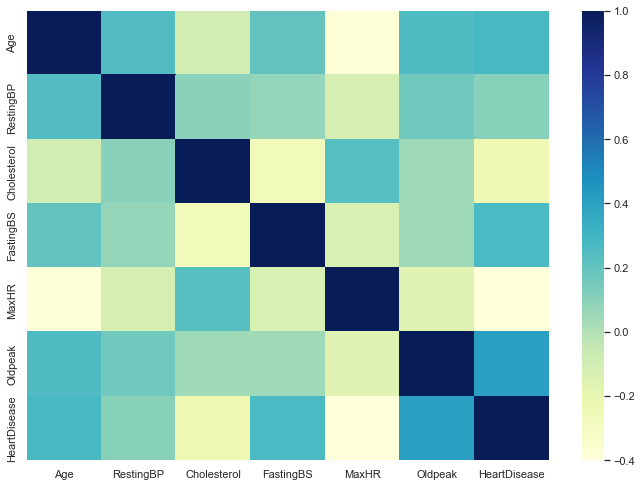

In [7]:
sns.heatmap(heart.corr(),cmap="YlGnBu")

Lets plot the relation between the two variables to see trends

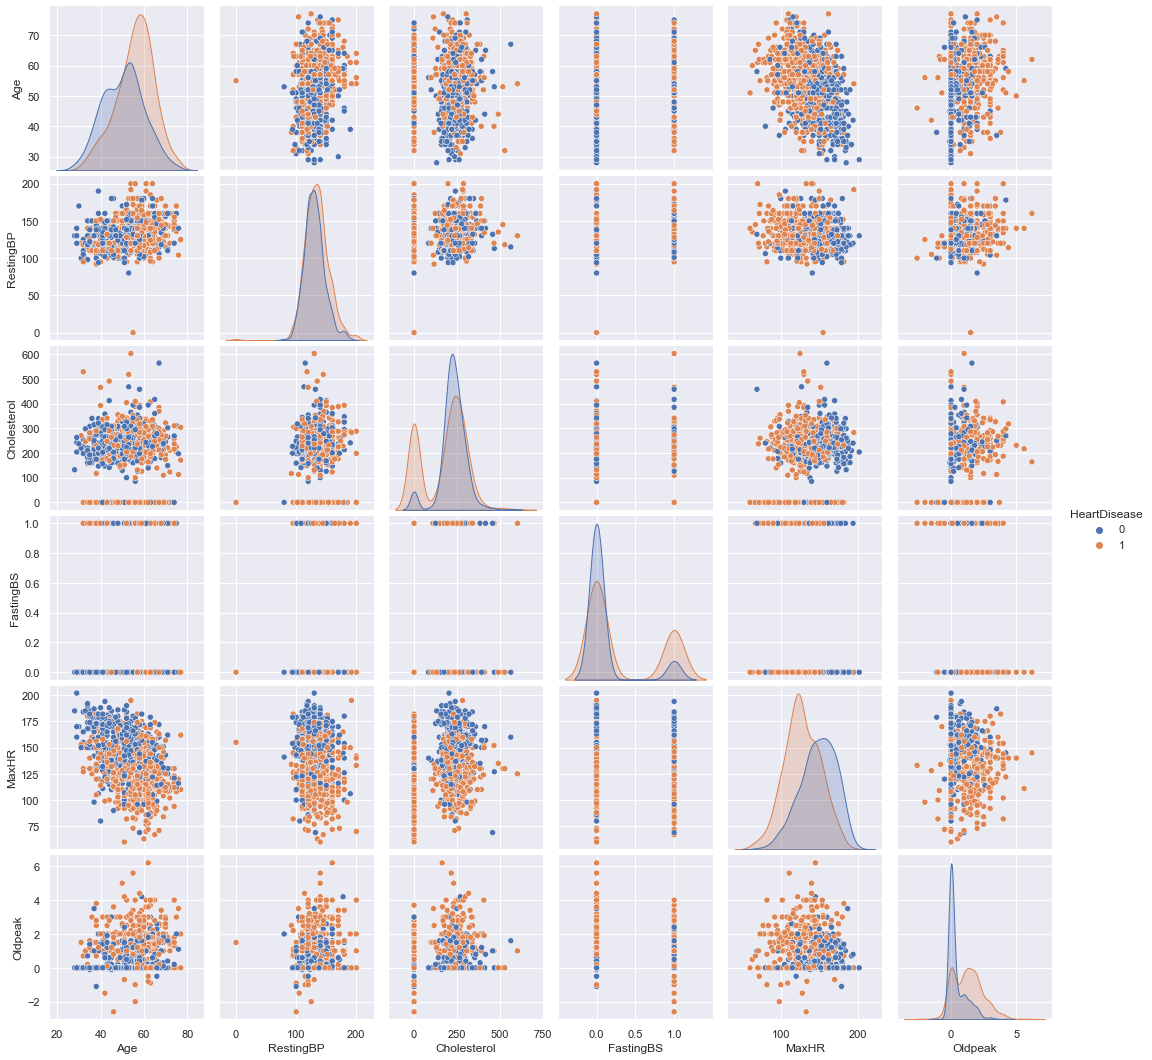

In [8]:
sns.pairplot(heart,hue="HeartDisease")

Lets check outliers

<AxesSubplot:>

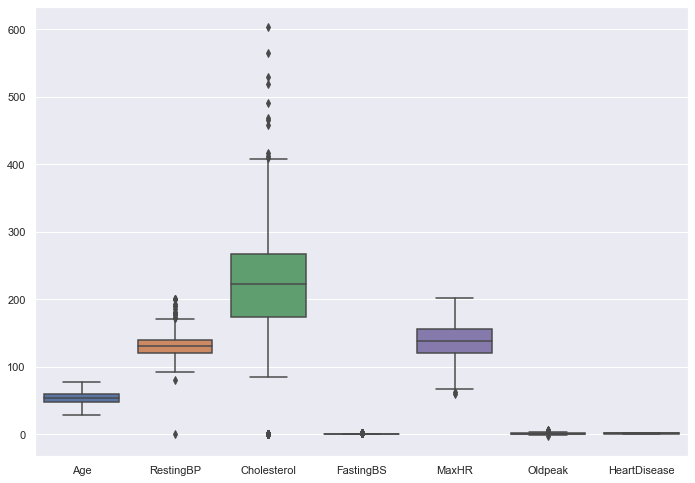

In [9]:
sns.boxplot(data=heart)

Resting can not be 0 and cholesterol also can not be 0, indicating in those cases that when there is missing data they put a 0.

In [10]:
#lets check RestingBp
heart[heart["RestingBP"]<20]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [11]:
#lets remove it for lack of information, and its just one input among a thousand
heart=heart.drop(labels=449, axis=0)

Now lets check cholesterol


<AxesSubplot:ylabel='Cholesterol'>

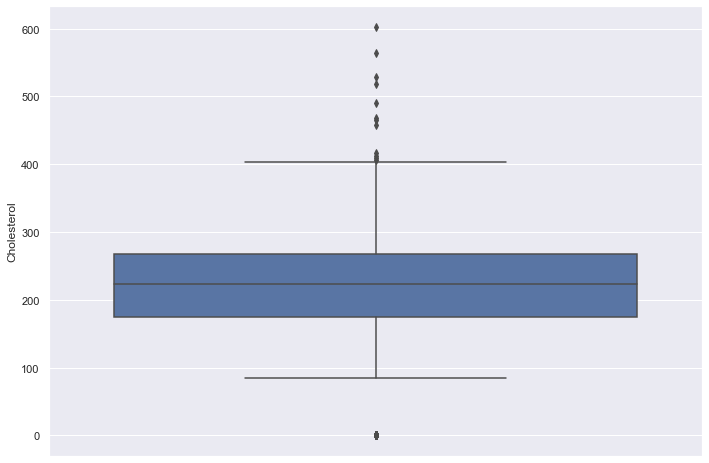

In [12]:
sns.boxplot(y="Cholesterol",data=heart)

In [13]:
heart[heart["Cholesterol"]==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


There is a lot of data with colesterol missing , more than 15%. Lets check the values of this data


In [14]:
heart[heart["Cholesterol"]<20]["HeartDisease"].value_counts()

1    151
0     20
Name: HeartDisease, dtype: int64

It is far from being 50/50, it is highly skewed, so something must be done, so I will use the median of people with heart disease to this missing data, as a first approximation

In [15]:
mask = (heart["Cholesterol" ]!= 0) & (heart["HeartDisease"] == 1)
heart.loc[mask]["Cholesterol"].median()

246.0

In [16]:
heart.loc[heart["Cholesterol"]==0,"Cholesterol"] = heart.loc[mask]["Cholesterol"].median()

lets use the model tree based algoritm

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [18]:
heart_dummy = pd.get_dummies(heart)
X = heart_dummy.drop(axis=1,labels="HeartDisease")
y = heart_dummy["HeartDisease"]

In [19]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=10)#train and test data

In [20]:
Stimator = DecisionTreeClassifier(criterion="entropy",random_state = 101)
grid = {"max_depth" : [1,2,3,4,5,6,7,8,9]}
gso = GridSearchCV(Stimator,grid,cv=5)#optimize hyperparameters and prevent overfitting

In [21]:
gso.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=101),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]})

In [22]:
y_pred = gso.predict(x_test)

In [23]:
from sklearn.metrics import confusion_matrix,accuracy_score,plot_confusion_matrix
confusion_matrix(y_test,y_pred)

array([[105,  19],
       [ 20, 132]], dtype=int64)

C:\miniconda3\envs\dyc\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


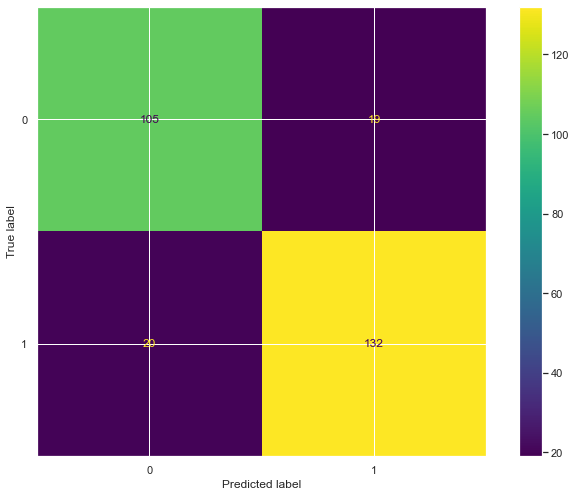

In [24]:
plot_confusion_matrix(gso,x_test,y_test)#Lets plot confusion matrix

In [25]:
accuracy_score(y_test,y_pred)

0.8586956521739131

85 percent, looks pretty good for a first approach
